In [2]:
import sys
import argparse



from tqdm import tqdm, trange
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToPILImage, Resize, ToTensor, Normalize, Compose

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

from sklearn import metrics

from preprocess2D import *
from preprocess3D import *
from dataset2D import *
from dataset3D import *
from model import *
from nnPULoss import *
from trainer import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'unet-nnpu-brats2020/'

In [3]:

# train_data_3D, valid_data_3D = preprocess_brats2020_3D(root_dir='MICCAI_BraTS2020_TrainingData/', ratio_train_valid= 0.8, ratio_P_to_U= 0.95)
train_data, valid_data = preprocess_brats2020_2D(root_dir='MICCAI_BraTS2020_TrainingData/', ratio_train_valid= 0.8, ratio_P_to_U= 0.95)

2D BraTS2020 already present with:
	RatioTrainValid: 0.8	RatioPosToNeg: 0.95


In [31]:
train_dataset = PU_BraTS2020_Dataset_2D(train_data)
valid_dataset = PN_BraTS2020_Dataset_2D(valid_data)
# # train_dataset_3D = PU_BraTS2020_Dataset_3D(train_data_3D)
# print(train_dataset[0]['img'].shape, train_dataset_3D[0]['img'].shape)
# print(train_dataset[0]['target'].shape, train_dataset_3D[0]['target'].shape)
# print(torch.unique(train_dataset[1]['target']),torch.unique(train_dataset_3D[1]['target']))

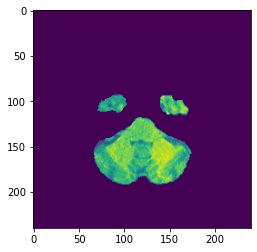

In [37]:
plt.imshow(np.load('2D_BraTS2020 RatioTrainValid 0.8 RatioPosToNeg 0.95/BraTS2020_Valid/BraTS20_Training_002/T1/27/seg.npy'))

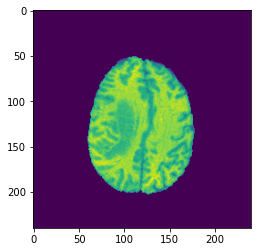

In [40]:
plt.imshow(np.load('2D_BraTS2020 RatioTrainValid 0.8 RatioPosToNeg 0.95/BraTS2020_Train/BraTS20_Training_001/T1/101/img.npy'))

In [5]:
from run_train import select_dataloader
print(len(train_data[0]), len(valid_data[0]))

t_data, v_data = (train_data[0][:16], train_data[1]) , (valid_data[0][:16], valid_data[1])

print(len(t_data[0]), len(v_data[0]))
train_dataloader, valid_dataloader,_ = select_dataloader(True, train_data, valid_data, "nnPULoss", 8, is_validation= True, num_worker= 8, prior= 0.5)

94 94
16 16
IMG status: torch.Size([1, 240, 240]) torch.float32 torch.FloatTensor
SEG status: torch.Size([240, 240]) torch.float32 torch.FloatTensor


In [23]:
data = next(iter(valid_dataloader))

In [24]:
# print(np.unique(data['target'][0]))
# print(np.count_nonzero(data['target'][0]==0), np.count_nonzero(data['target'][0]==1), data['target'][0].size())
# plt.hist(data['target'][0])

In [25]:
# # print(np.unique(data['img'][0]))
# print(np.count_nonzero(data['img'][0]==0), np.count_nonzero(data['img'][0]!=0), data['img'][0].size())
# plt.hist(data['img'][0].squeeze())

In [26]:
model = unet()
model.load_state_dict(torch.load('model_saved_pr= 0.5 lr=0.001/epoch_100_checkpoint',map_location=torch.device('cpu')))
output = model(data['img'])
model_more_trained = unet()
model_more_trained.load_state_dict(torch.load('model_saved_pr= 0.5 lr=0.001/epoch_200_checkpoint',map_location=torch.device('cpu')))
output_more_trained = model_more_trained(data['img'])

13960


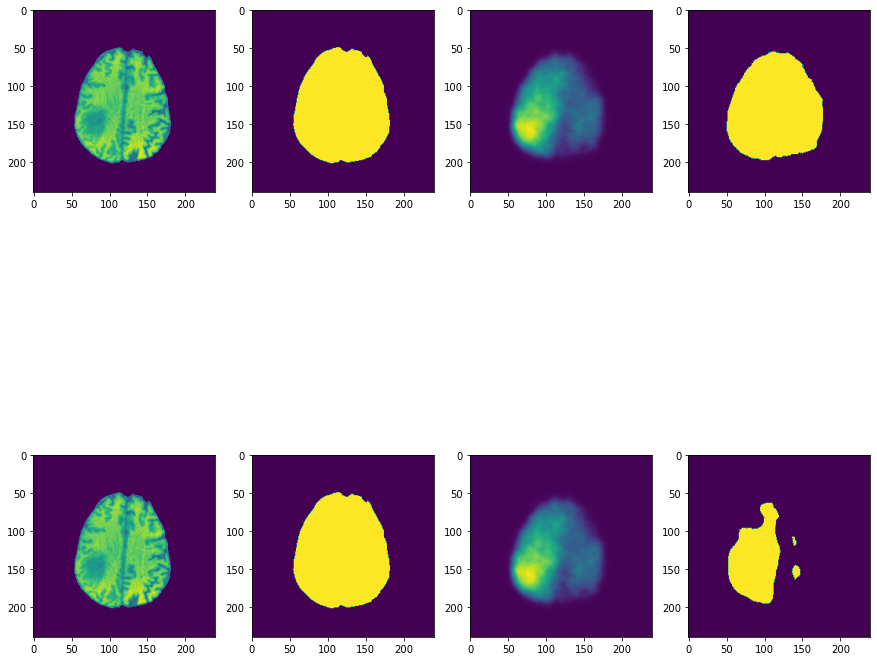

In [27]:
id = 6
greater_than =0
f, arr = plt.subplots(2,4, figsize=(15,15))
arr[0,0].imshow(data['img'][id].squeeze())
arr[0,1].imshow(data['target'][id].squeeze())
arr[0,2].imshow(output.detach().numpy().squeeze()[id])
arr[0,3].imshow(torch.where(output>greater_than, 1,0).detach().numpy().squeeze()[id])
arr[1,0].imshow(data['img'][id].squeeze())
arr[1,1].imshow(data['target'][id].squeeze())
arr[1,2].imshow(output.detach().numpy().squeeze()[id])
arr[1,3].imshow(torch.where(output_more_trained>greater_than, 1,0).detach().numpy().squeeze()[id])
print(np.count_nonzero(output[id]>0))

13960


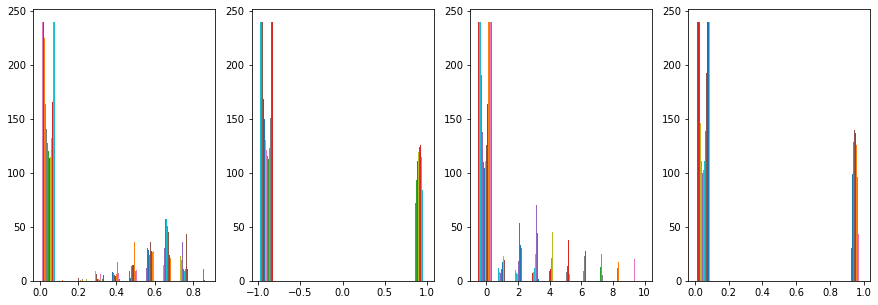

In [28]:
f, arr = plt.subplots(1,4, figsize=(15,5))
arr[0].hist(data['img'][id].squeeze())
arr[1].hist(data['target'][id].squeeze())
arr[2].hist(output.detach().numpy().squeeze()[id])
arr[3].hist(torch.where(output>greater_than, 1,0).detach().numpy().squeeze()[id])
print(np.count_nonzero(output[id]>0))